### Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.



### Import all the important libraries

In [64]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
import keras.layers.experimental.preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.utils import to_categorical


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Data Reading/Data Understanding

In [3]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_data_assignment.zip" > /dev/null

In [5]:
# Define the path for both train and test images from dataset
#data_dir_train = pathlib.Path("/content/Skin cancer ISIC data/Train/")
#data_dir_test = pathlib.Path("/content/Skin cancer ISIC data/Test/")
data_dir_train = pathlib.Path("./dataset/Train")
data_dir_test = pathlib.Path('./dataset/Test')

In [7]:
# Count the number of image in Train and Test folder
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Dataset creation

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Train dataset
## Note use seed=123 while creating your dataset
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Validation dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# We can find the class names in the class_names attribute on these datasets.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Dataset Visualization

Create a code to visualize one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.


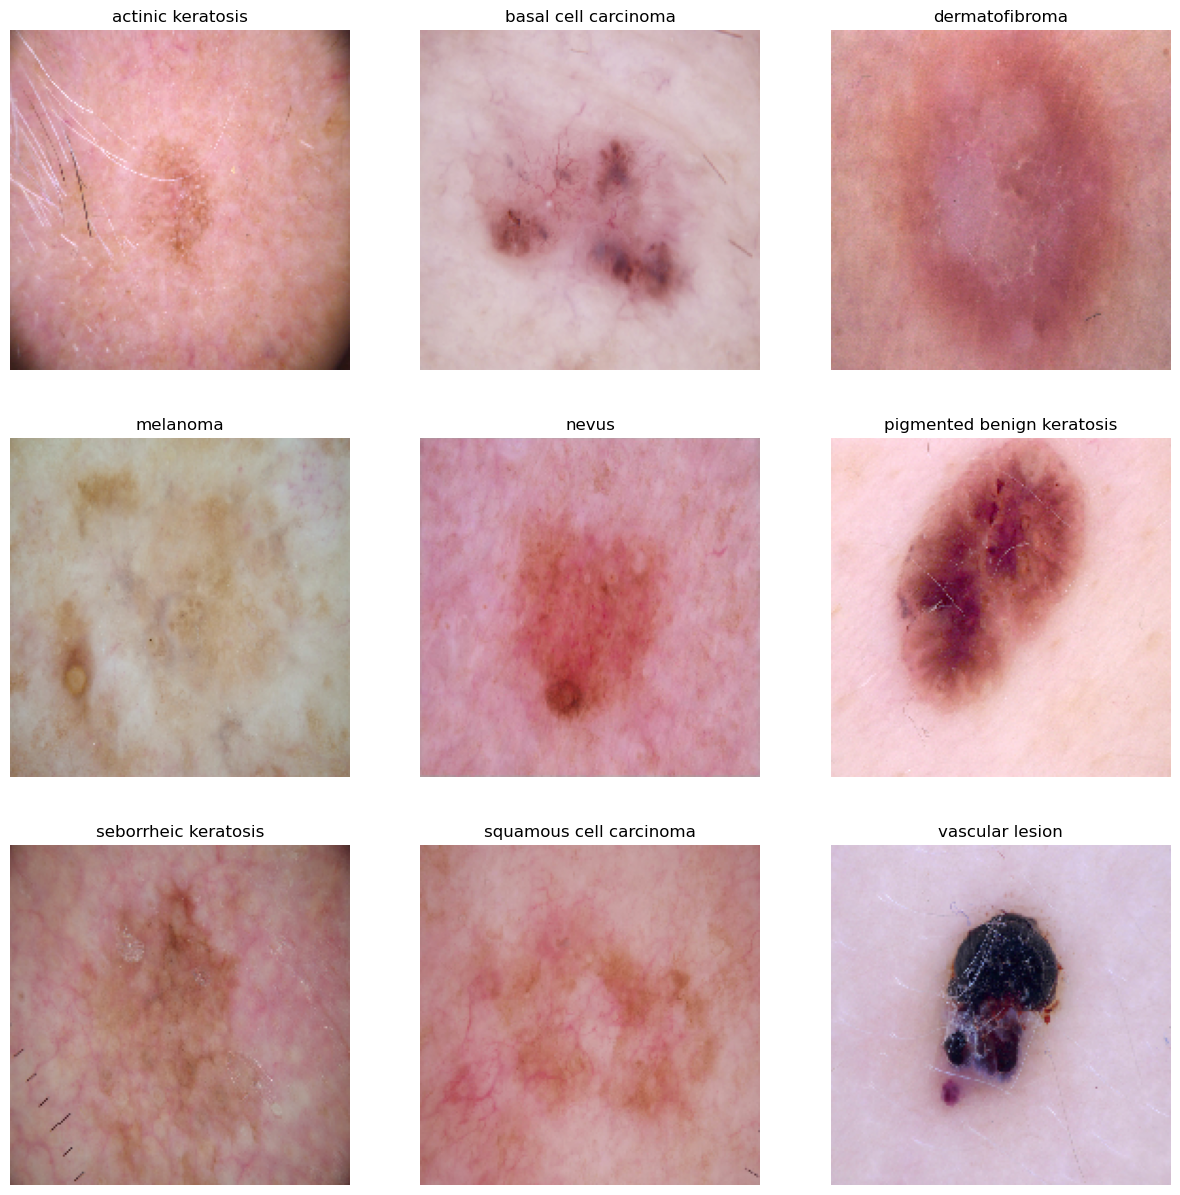

In [12]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Class Distribution
##### Visualize distribution of classes in the training dataset

In [14]:

def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

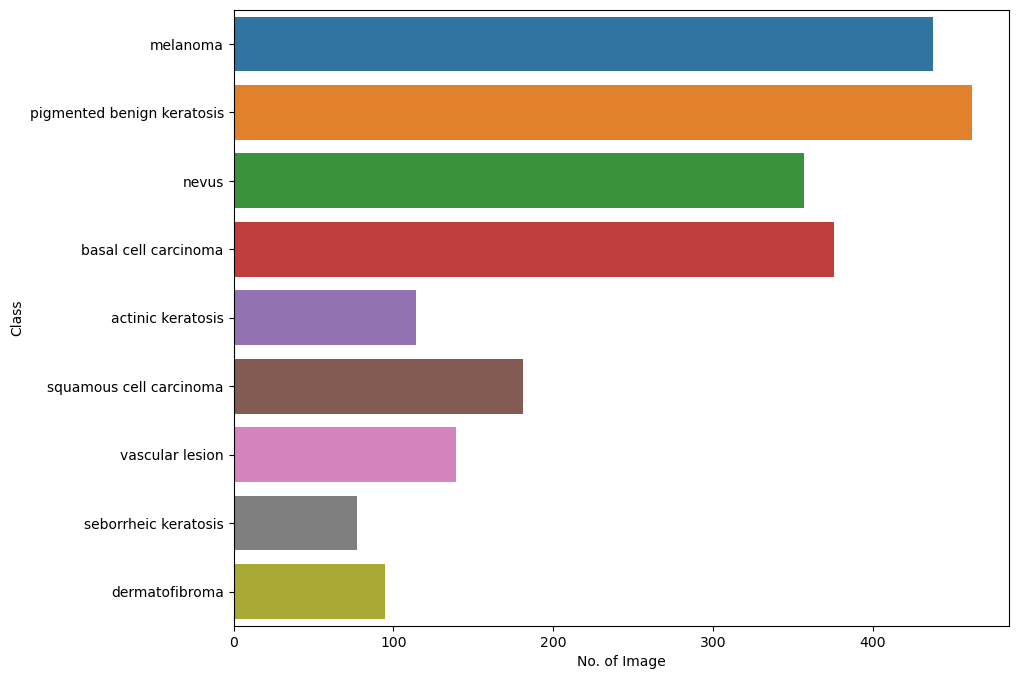

In [15]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

### Create model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. 
Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). 
The RGB channel values are in the `[0, 255]` range. 
This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [18]:
## compile the model
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 180ms/step - loss: 1.9829 - accuracy: 0.2930 - val_loss: 1.9134 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 9s 159ms/step - loss: 1.6474 - accuracy: 0.4141 - val_loss: 1.4874 - val_accuracy: 0.4966
Epoch 3/20
56/56 [==============================] - 9s 166ms/step - loss: 1.4536 - accuracy: 0.4933 - val_loss: 1.4662 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 9s 165ms/step - loss: 1.3432 - accuracy: 0.5240 - val_loss: 1.5603 - val_accuracy: 0.4676
Epoch 5/20
56/56 [==============================] - 9s 160ms/step - loss: 1.2688 - accuracy: 0.5547 - val_loss: 1.4500 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 9s 155ms/step - loss: 1.2308 - accuracy: 0.5592 - val_loss: 1.5628 - val_accuracy: 0.4765
Epoch 7/20
56/56 [==============================] - 9s 153ms/step - loss: 1.1571 - accuracy: 0.5820 - val_loss: 1.3883 - val_accuracy: 0.5257
Epoch

### Train the model

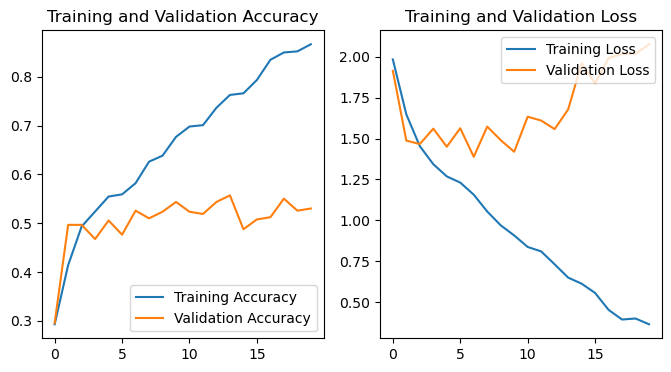

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Data augmentation

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

In [23]:
for images, _ in train_ds.take(1):
    print("Number of images:", len(images))
    print("Image shape:", images[0].shape)
    print("Image data type:", images[0].dtype)


Number of images: 32
Image shape: (180, 180, 3)
Image data type: <dtype: 'float32'>


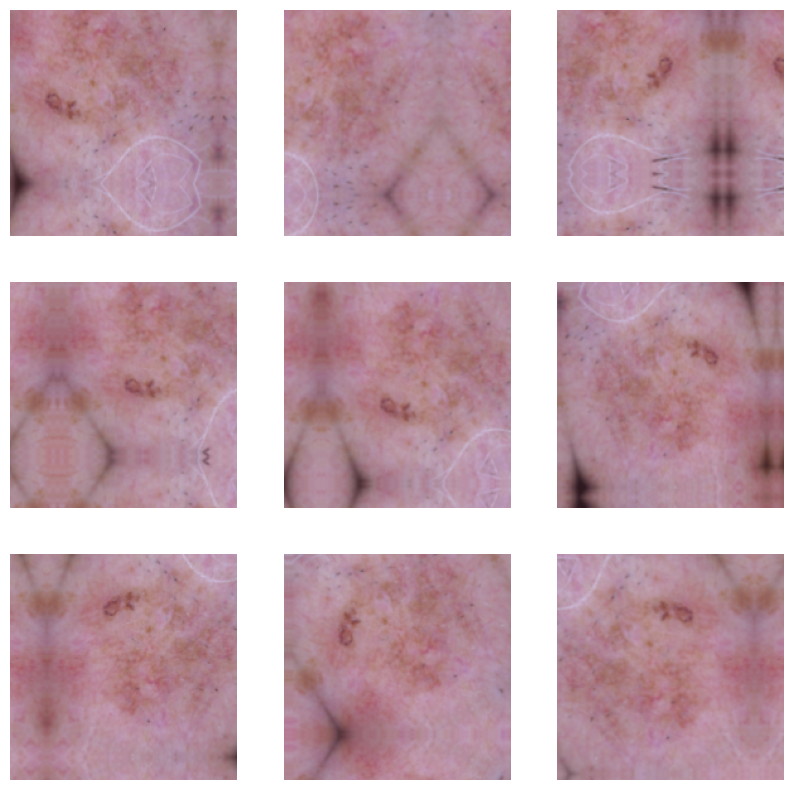

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 63s 1s/step - loss: 2.2987 - accuracy: 0.1975 - val_loss: 1.9183 - val_accuracy: 0.3065
Epoch 2/20
56/56 [==============================] - 65s 1s/step - loss: 1.8265 - accuracy: 0.3454 - val_loss: 1.7450 - val_accuracy: 0.3468
Epoch 3/20
56/56 [==============================] - 68s 1s/step - loss: 1.6945 - accuracy: 0.3705 - val_loss: 1.6524 - val_accuracy: 0.3758
Epoch 4/20
56/56 [==============================] - 72s 1s/step - loss: 1.6808 - accuracy: 0.3650 - val_loss: 1.6415 - val_accuracy: 0.3937
Epoch 5/20
56/56 [==============================] - 74s 1s/step - loss: 1.6499 - accuracy: 0.3705 - val_loss: 1.6279 - val_accuracy: 0.3915
Epoch 6/20
56/56 [==============================] - 70s 1s/step - loss: 1.6615 - accuracy: 0.3789 - val_loss: 1.6042 - val_accuracy: 0.4206
Epoch 7/20
56/56 [==============================] - 68s 1s/step - loss: 1.6022 - accuracy: 0.4074 - val_loss: 1.5669 - val_accuracy: 0.4318
Epoch 8/20
56/56 [==

### Visualizing the results

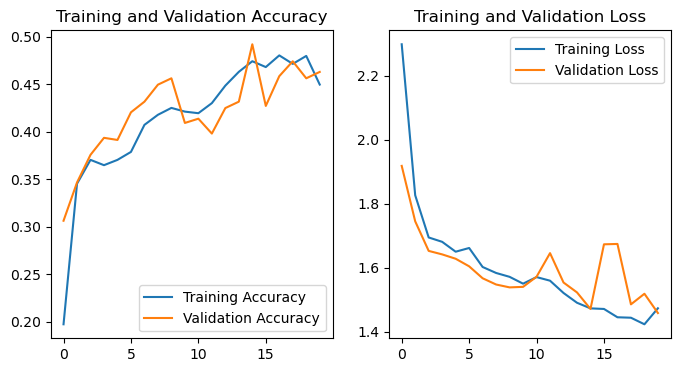

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
# For convenience, let us set up the path for the training and validation sets
train_dir = os.path.join('./dataset/Train')
val_dir = os.path.join('./dataset/Test')

In [33]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224

# Create training images generator
#Generate batches of tensor image data with real-time data augmentation.
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
#https://keras.io/api/preprocessing/image/
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [34]:
#Create a CNN model
#Experiment #1
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

# Import layers explicitly to keep our code compact
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


model = Sequential()

#2D convolution layer (e.g. spatial convolution over images).
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))

#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flattens the input. Does not affect the batch size.
model.add(Flatten())

#https://keras.io/api/layers/regularization_layers/dropout/
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))

#Just your regular densely-connected NN layer.
#Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
#It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
#Dense implements the operation: output = activation(dot(input, kernel)
model.add(Dense(9))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=10
)


Epoch 1/10
23/23 [==============================] - 47s 2s/step - loss: 3.7163 - accuracy: 0.1836 - val_loss: 2.3463 - val_accuracy: 0.1695
Epoch 2/10
23/23 [==============================] - 43s 2s/step - loss: 1.8516 - accuracy: 0.3068 - val_loss: 2.3358 - val_accuracy: 0.3305
Epoch 3/10
23/23 [==============================] - 43s 2s/step - loss: 1.6606 - accuracy: 0.4216 - val_loss: 2.3766 - val_accuracy: 0.2881
Epoch 4/10
23/23 [==============================] - 45s 2s/step - loss: 1.5139 - accuracy: 0.4672 - val_loss: 2.1835 - val_accuracy: 0.3390
Epoch 5/10
23/23 [==============================] - 49s 2s/step - loss: 1.4437 - accuracy: 0.4962 - val_loss: 2.0683 - val_accuracy: 0.2881
Epoch 6/10
23/23 [==============================] - 44s 2s/step - loss: 1.4214 - accuracy: 0.4917 - val_loss: 2.2668 - val_accuracy: 0.3475
Epoch 7/10
23/23 [==============================] - 43s 2s/step - loss: 1.3663 - accuracy: 0.5150 - val_loss: 2.4271 - val_accuracy: 0.3559
Epoch 8/10
23/23 [==

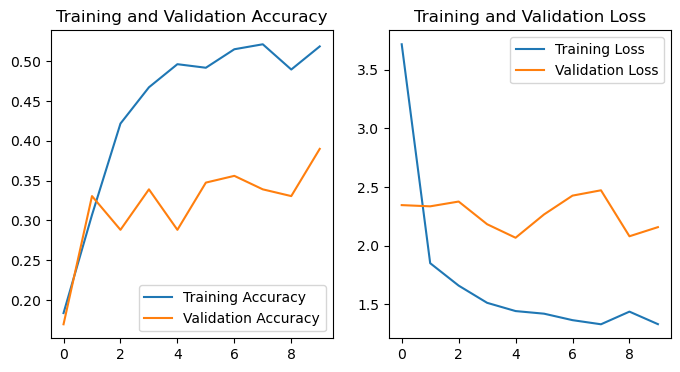

In [35]:
import matplotlib.pyplot as plt
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)



plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [36]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [37]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,dataset/Train/melanoma/ISIC_0010550.jpg,melanoma
1,dataset/Train/melanoma/ISIC_0011128.jpg,melanoma
2,dataset/Train/melanoma/ISIC_0010587.jpg,melanoma
3,dataset/Train/melanoma/ISIC_0010034.jpg,melanoma
4,dataset/Train/melanoma/ISIC_0000555.jpg,melanoma
...,...,...
2234,dataset/Train/dermatofibroma/ISIC_0033554.jpg,dermatofibroma
2235,dataset/Train/dermatofibroma/ISIC_0027044.jpg,dermatofibroma
2236,dataset/Train/dermatofibroma/ISIC_0033780.jpg,dermatofibroma
2237,dataset/Train/dermatofibroma/ISIC_0033810.jpg,dermatofibroma


Class=3, n=438 (19.562%)
Class=5, n=462 (20.634%)
Class=4, n=357 (15.945%)
Class=1, n=376 (16.793%)
Class=0, n=114 (5.092%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=2, n=95 (4.243%)


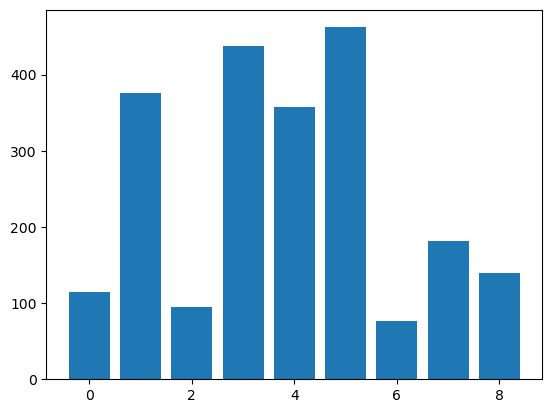

In [38]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [39]:
!pip install Augmentor

In [41]:
datapath = r'./dataset/Train/actinic keratosis'
import Augmentor
p = Augmentor.Pipeline(datapath)
#Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.zoom(probability=0.2, min_factor=1.1, max_factor=1.2)
p.sample(300)
p.process()


Initialised with 114 image(s) found.
Output directory set to ./dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28907BF50>: 100%|███████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 205.74 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1397646D0>: 100%|███████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.06 Samples/s]


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [42]:
path_to_training_dataset="./dataset/Train//"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./dataset/Train//actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28927A350>: 100%|███████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 248.24 Samples/s]


Initialised with 376 image(s) found.
Output directory set to ./dataset/Train//basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1397FB790>: 100%|███████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 258.74 Samples/s]


Initialised with 95 image(s) found.
Output directory set to ./dataset/Train//dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x13809DB50>: 100%|███████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 245.59 Samples/s]


Initialised with 438 image(s) found.
Output directory set to ./dataset/Train//melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x139827B90>: 100%|███████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 51.19 Samples/s]


Initialised with 357 image(s) found.
Output directory set to ./dataset/Train//nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x139715B50>: 100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 59.17 Samples/s]


Initialised with 462 image(s) found.
Output directory set to ./dataset/Train//pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x13979A5D0>: 100%|█████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 233.17 Samples/s]


Initialised with 77 image(s) found.
Output directory set to ./dataset/Train//seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2891CEDD0>: 100%|███████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 98.96 Samples/s]


Initialised with 181 image(s) found.
Output directory set to ./dataset/Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1396FEDD0>: 100%|███████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 223.37 Samples/s]


Initialised with 139 image(s) found.
Output directory set to ./dataset/Train//vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x139433B50>: 100%|███████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 232.43 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4914


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['dataset/Train/melanoma/output/melanoma_original_ISIC_0011178.jpg_76fbbdf8-93a0-43c5-8ebf-aaeb13af5f04.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0011056.jpg_b12fd488-1177-4200-8ae6-c956a94f22b0.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0001102.jpg_5939cada-25e3-4255-bf51-9d6a61cf04b3.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0010978.jpg_c63c5130-b500-4bb8-bc53-96ec29d8ad0a.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0010288.jpg_a7356da4-0195-41ee-885f-82f30bc119d6.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0000428.jpg_11d641ce-f0e4-47f5-b3f3-619fd233213c.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0000555.jpg_cde49a77-bea5-45b2-9920-84645fb78486.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0010796.jpg_4dc0c0d8-b921-46f0-b7b3-28e12b2e205a.jpg',
 'dataset/Train/melanoma/output/melanoma_original_ISIC_0011178.jpg_e3928977-bdd4-4be2-bcef-8576d032946f.jpg',
 'dataset/

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [48]:
df_dict_new = dict(zip(path_list_new, lesion_list_new))

In [49]:
df2 = pd.DataFrame(list(df_dict_new.items()),columns = ['Path','Label'])

new_df = pd.concat([original_df, df2])

In [50]:
original_df.head(2)

,Path,Label
0,dataset/Train/melanoma/ISIC_0010550.jpg,melanoma
1,dataset/Train/melanoma/ISIC_0011128.jpg,melanoma


In [51]:
df2.head(2)

,Path,Label
0,dataset/Train/melanoma/output/melanoma_origina...,melanoma
1,dataset/Train/melanoma/output/melanoma_origina...,melanoma


In [52]:
new_df['Label'].value_counts()

Label
actinic keratosis             1028
pigmented benign keratosis     962
melanoma                       938
basal cell carcinoma           876
nevus                          857
squamous cell carcinoma        681
vascular lesion                639
dermatofibroma                 595
seborrheic keratosis           577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Model Building & training on the augmented data 

In [53]:
batch_size = 32
img_height = 180
img_width = 180

#### Create Training dataset

In [54]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7153 files belonging to 9 classes.
Using 5723 files for training.


#### Create Validation dataset

In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7153 files belonging to 9 classes.
Using 1430 files for validation.


#### Create model (make sure to include normalization)

In [59]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile the model (Choose optimizer and loss function appropriately)

In [62]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Model Building & training on the rectified class imbalance data (Epoch 30)

In [63]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
179/179 [==============================] - 40s 172ms/step - loss: 1.7666 - accuracy: 0.3313 - val_loss: 1.4505 - val_accuracy: 0.4615
Epoch 2/30
179/179 [==============================] - 31s 174ms/step - loss: 1.4167 - accuracy: 0.4732 - val_loss: 1.2660 - val_accuracy: 0.5385
Epoch 3/30
179/179 [==============================] - 34s 188ms/step - loss: 1.1974 - accuracy: 0.5644 - val_loss: 1.1379 - val_accuracy: 0.5727
Epoch 4/30
179/179 [==============================] - 33s 185ms/step - loss: 1.0283 - accuracy: 0.6296 - val_loss: 1.0397 - val_accuracy: 0.6175
Epoch 5/30
179/179 [==============================] - 32s 179ms/step - loss: 0.8461 - accuracy: 0.6993 - val_loss: 0.9063 - val_accuracy: 0.6762
Epoch 6/30
179/179 [==============================] - 33s 185ms/step - loss: 0.7337 - accuracy: 0.7330 - val_loss: 0.8749 - val_accuracy: 0.6881
Epoch 7/30
179/179 [==============================] - 35s 195ms/step - loss: 0.6169 - accuracy: 0.7790 - val_loss: 0.8408 - val_ac

#### Visualize the results of the Model

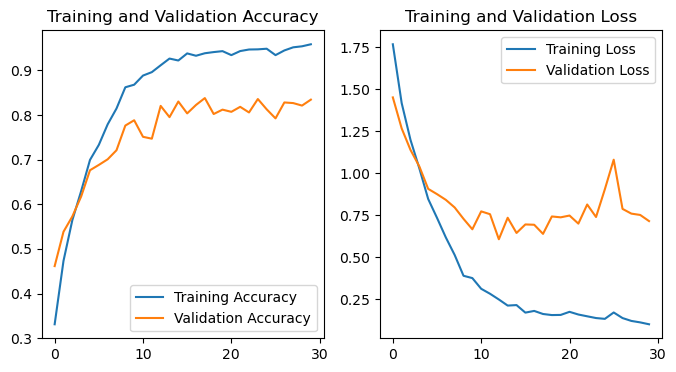

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Did you get rid of underfitting/overfitting? Did class rebalance help?

The class rebalancing notably mitigated overfitting, resulting in a reduction in loss. However, it led to a significant decrease in accuracy.

Initially, we experimented without utilizing the ImageDataGenerator, leading to severe overfitting issues.

Subsequently, we incorporated dropout and ImageDataGenerator techniques, effectively mitigating overfitting.

Finally, we implemented Batch Normalization and augmentation, resulting in further improvements and addressing the overfitting challenges.